# API를 활용하여 아파트매매 실거래 데이터 가져오기

## 활용 데이터

공공데이터포털 > 국토교통부_아파트매매 실거래 상세 자료 <br>
https://www.data.go.kr/data/15057511/openapi.do

# 📌기초 - 데이터 수집

### 라이브러리 불러오기

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
from time import strftime

import os
import matplotlib.pyplot as plt
import seaborn as sns

from PublicDataReader import TransactionPrice
import PublicDataReader as pdr
from xml.etree import ElementTree as ET

In [3]:
%matplotlib inline

# 시각화를 위한 폰트 설정
if os.name == "posix":
    sns.set(font="AppleGothic")
elif os.name == "nt":
    sns.set(font="Malgun Gothic")
    
# 레티나 설정을 해주면 글씨가 좀더 선명하게 보임
# 폰트의 주변이 흐릿하게 보이는 것을 방지
%config InlineBackend.figure_format='retina'

### 쿼리 값 세팅

In [4]:
key =  'API 키를 입력해주세요'
LAWD_CD = '11200' # 지역코드
DEAL_YMD = '202301'

# f-string 방식
query = f'?serviceKey={key}&pageNo=1&numOfRows=99999&LAWD_CD={LAWD_CD}&DEAL_YMD={DEAL_YMD}'

# dictionary 방식
params ={'serviceKey' : key, 'numOfRows' : '99999', 'LAWD_CD' : LAWD_CD , 'DEAL_YMD' : DEAL_YMD}

### url 세팅

In [5]:
url = 'http://openapi.molit.go.kr/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTradeDev'
rq_url = url + query

### GET OK 200 확인

In [6]:
# f-string
# response = requests.get(rq_url)

# dictionary
response = requests.get(url, params=params)

response

<Response [200]>

### 컬럼 매핑

In [7]:
# 방법 1
result = bs(response.text, features='xml')
items = result.findAll('item')

# # 방법 2 : soup의 내용은 response.text 결과와 같지만 타입이 다르다.
# soup = bs(response.content, 'lxml-xml')
# items = soup.findAll('item')

# 컬럼명 찾기
columns = items[0].find_all()
columns[0].name

cols = []

for i in range(0, len(columns)):
    cols.append(columns[i].name)

### 내용 가져오기

In [8]:
# 문서 내 모든 텍스트 값 가져오기
all_txt = []

for c in range(0,len(cols)):
    col = cols[c]
    for a in result.select(col):
        all_txt.append(a.text.strip())

In [9]:
# 개별 거래내역별로 묶기
sorted_txt = []

for i in range(len(result.items)):
    temp = []
    a = list(range(i, len(all_txt), len(result.items)))
    for j in a:
        temp.append(all_txt[j])
    sorted_txt.append(temp)

In [10]:
# 컬럼과 내용 병합
df = pd.DataFrame(sorted_txt, columns = cols)
display(df)
df.shape

,거래금액,거래유형,건축년도,년,도로명,도로명건물본번호코드,도로명건물부번호코드,도로명시군구코드,도로명일련번호코드,도로명코드,...,월,일,일련번호,전용면적,중개사소재지,지번,지역코드,층,해제사유발생일,해제여부
0,"155,000",중개거래,2016,2023,왕십리로,00410,00000,11200,00,3005011,...,1,11,11200-3120,84.96,서울 성동구,1070,11200,21,,
1,"83,000",중개거래,2000,2023,행당로,00079,00000,11200,01,3103006,...,1,9,11200-18,59.96,서울 성동구,347,11200,6,,
2,"129,000",중개거래,2003,2023,고산자로,00164,00000,11200,04,3005030,...,1,11,11200-24,114.97,서울 성동구,349,11200,14,,
3,"186,000",중개거래,2007,2023,금호로,00015,00000,11200,03,3103001,...,1,14,11200-2820,84.87,서울 성동구,340,11200,17,,
4,"133,000",중개거래,2012,2023,매봉길,00015,00000,11200,02,4109229,...,1,9,11200-2980,59.25,서울 성동구,561,11200,18,,
5,"124,000",중개거래,2016,2023,매봉길,00050,00000,11200,00,4109229,...,1,19,11200-3114,59.91,서울 성동구,528,11200,6,,
6,"101,000",중개거래,1990,2023,서울숲길,00025,00000,11200,01,4109323,...,1,2,11200-61,84.73,서울 성동구,676-5,11200,13,,


(7, 27)

In [11]:
# 컬럼을 편집하고 싶을 경우
# edit_cols = ['년','월','일','거래유형','지역코드','도로명', '법정동','지번','아파트','층','건축년도','전용면적','거래금액']
# df = df[edit_cols]

# 컬럼을 특정 데이터로 정렬하고 싶을 경우
# df.sort_values(['층'])

### 파일 저장

In [12]:
file_name = 'API_LandCost_' + strftime('%Y-%m-%d-%H-%M') + '.csv'
df.to_csv(file_name, index=False)
print(file_name)
pd.read_csv(file_name)

API_LandCost_2023-01-29-20-16.csv


,거래금액,거래유형,건축년도,년,도로명,도로명건물본번호코드,도로명건물부번호코드,도로명시군구코드,도로명일련번호코드,도로명코드,...,월,일,일련번호,전용면적,중개사소재지,지번,지역코드,층,해제사유발생일,해제여부
0,"155,000",중개거래,2016,2023,왕십리로,410,0,11200,0,3005011,...,1,11,11200-3120,84.96,서울 성동구,1070,11200,21,NaN,NaN
1,"83,000",중개거래,2000,2023,행당로,79,0,11200,1,3103006,...,1,9,11200-18,59.96,서울 성동구,347,11200,6,NaN,NaN
2,"129,000",중개거래,2003,2023,고산자로,164,0,11200,4,3005030,...,1,11,11200-24,114.97,서울 성동구,349,11200,14,NaN,NaN
3,"186,000",중개거래,2007,2023,금호로,15,0,11200,3,3103001,...,1,14,11200-2820,84.87,서울 성동구,340,11200,17,NaN,NaN
4,"133,000",중개거래,2012,2023,매봉길,15,0,11200,2,4109229,...,1,9,11200-2980,59.25,서울 성동구,561,11200,18,NaN,NaN
5,"124,000",중개거래,2016,2023,매봉길,50,0,11200,0,4109229,...,1,19,11200-3114,59.91,서울 성동구,528,11200,6,NaN,NaN
6,"101,000",중개거래,1990,2023,서울숲길,25,0,11200,1,4109323,...,1,2,11200-61,84.73,서울 성동구,676-5,11200,13,NaN,NaN


# 📌심화 - 데이터 분석

### 숫자 데이터 형 변환

In [13]:
# int 타입이어야 하는 컬럼 : 거래금액, 건축년도, 년, 월, 일, 층
# float 타입이어야 하는 컬럼 : 전용면적

In [14]:
#public data reader 코드 중 컬럼 내 데이터 타입 변환 참고
int_cols = ['거래금액', '건축년도', '년', '월', '일', '층']
float_cols = ['전용면적']

for col in int_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].apply(
            lambda x: x.strip().replace(",", "") if x is not None and not pd.isnull(x) else x)).astype("Int64")
for col in float_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col])

In [15]:
# 숫자형으로 잘 변환됐는지 확인

print(type(df.거래금액[0]))
print(df.거래금액[0] + df.거래금액[1])

<class 'numpy.int64'>
238000


### 단위 변경(m² > 평)

In [16]:
pyong = [round(var/ 3.305785, 1) for var in df['전용면적']]
df['평형'] = pyong

In [17]:
df[['년', '월', '일', '아파트', '층', '건축년도', '전용면적', '평형', '거래금액']]

,년,월,일,아파트,층,건축년도,전용면적,평형,거래금액
0,2023,1,11,센트라스,21,2016,84.96,25.7,155000
1,2023,1,9,대림e-편한세상,6,2000,59.96,18.1,83000
2,2023,1,11,서울숲 한신 더 휴,14,2003,114.97,34.8,129000
3,2023,1,14,서울숲푸르지오,17,2007,84.87,25.7,186000
4,2023,1,9,래미안 옥수 리버젠,18,2012,59.25,17.9,133000
5,2023,1,19,옥수파크힐스101동~116동,6,2016,59.91,18.1,124000
6,2023,1,2,서울숲성수현대,13,1990,84.73,25.6,101000


### 평당 가격 계산

In [18]:
cost_per_pyong = round(df['거래금액'] / df['평형'])
df['평당금액'] = cost_per_pyong

In [19]:
df[['년', '월', '일', '아파트', '층', '건축년도', '전용면적', '평형', '거래금액', '평당금액']]

,년,월,일,아파트,층,건축년도,전용면적,평형,거래금액,평당금액
0,2023,1,11,센트라스,21,2016,84.96,25.7,155000,6031.0
1,2023,1,9,대림e-편한세상,6,2000,59.96,18.1,83000,4586.0
2,2023,1,11,서울숲 한신 더 휴,14,2003,114.97,34.8,129000,3707.0
3,2023,1,14,서울숲푸르지오,17,2007,84.87,25.7,186000,7237.0
4,2023,1,9,래미안 옥수 리버젠,18,2012,59.25,17.9,133000,7430.0
5,2023,1,19,옥수파크힐스101동~116동,6,2016,59.91,18.1,124000,6851.0
6,2023,1,2,서울숲성수현대,13,1990,84.73,25.6,101000,3945.0


### 2022년 분당에서 가장 비싸게 거래된 아파트 🔥 

In [20]:
service_key = key
api = TransactionPrice(service_key)

In [21]:
# 구역코드 검색
sigungu_name = "분당구"
code = pdr.code_bdong()
code.loc[(code['시군구명'].str.contains(sigungu_name, na=False)) &
         (code['읍면동명'].isna())]

,시도코드,시도명,시군구코드,시군구명,법정동코드,읍면동명,동리명,생성일자,말소일자
5152,41,경기도,41135,성남시 분당구,4113500000,NaN,NaN,19910916,NaN


In [22]:
# 2022년 아파트 매매 
df_apt_dealing = api.get_data(
    property_type="아파트",
    trade_type="매매",
    sigungu_code="41135",
    start_year_month = '202201',
    end_year_month = '202212',
    verbose = True
    )
df_apt_dealing
# Index(['지역코드', '도로명', '법정동', '지번', '아파트', '건축년도', '층', '전용면적', '년', '월', '일',
#    '거래금액', '도로명건물본번호코드', '도로명건물부번호코드', '도로명시군구코드', '도로명일련번호코드',
#    '도로명지상지하코드', '도로명코드', '법정동본번코드', '법정동부번코드', '법정동시군구코드', '법정동읍면동코드',
#    '법정동지번코드', '일련번호', '거래유형', '중개사소재지', '해제사유발생일', '해제여부'],
#   dtype='object')
# 상기 데이터 중에서 필요한 값만 가져오기
df_apt_dealing.drop(labels=['지번','층','도로명건물본번호코드', '도로명건물부번호코드', '도로명시군구코드', '도로명일련번호코드',
                '도로명지상지하코드', '도로명코드', '법정동본번코드', '법정동부번코드', '법정동시군구코드', '법정동읍면동코드',
               '법정동지번코드', '일련번호','중개사소재지', '해제사유발생일', '해제여부'], axis = 1, inplace = True)
# 여러개의 컬럼 지울 때는 list에 할당 해준 후 없애기. inplace = True 해주어야 영구적으로 데이터에서 사라짐
cols = ['지역코드', '도로명', '법정동', '아파트', '건축년도','전용면적','년', '월', '일', '거래금액(단위 : 만원)',  '거래유형']
df_apt_dealing.columns = cols 
df_apt_dealing

202201
202202
202203
202204
202205
202206
202207
202208
202209
202210
202211
202212


,지역코드,도로명,법정동,아파트,건축년도,전용면적,년,월,일,거래금액(단위 : 만원),거래유형
0,41135,장안로51번길,분당동,장안타운(건영),1993,85.000,2022,1,12,110500,중개거래
1,41135,수내로,분당동,샛별마을(우방),1994,57.280,2022,1,21,98500,중개거래
2,41135,내정로174번길,수내동,파크타운(서안),1993,84.780,2022,1,3,136000,중개거래
3,41135,내정로165번길,수내동,양지마을(5단지)(한양501-514),1992,42.560,2022,1,5,63000,직거래
4,41135,수내로,수내동,푸른마을(신성),1992,59.780,2022,1,5,92000,중개거래
...,...,...,...,...,...,...,...,...,...,...,...
1086,41135,산운로,운중동,산운마을8단지(부영사랑으로),2008,59.612,2022,12,3,87500,중개거래
1087,41135,판교원로82번길,운중동,산운마을13단지(태영),2010,84.720,2022,12,9,113000,중개거래
1088,41135,판교원로,운중동,산운마을11단지(판교포레라움),2009,59.900,2022,12,10,100000,중개거래
1089,41135,판교원로,운중동,산운마을11단지(판교포레라움),2009,59.900,2022,12,10,100000,중개거래


In [23]:
df_apt_dealing[df_apt_dealing['거래금액(단위 : 만원)'] >= 490000]

,지역코드,도로명,법정동,아파트,건축년도,전용면적,년,월,일,거래금액(단위 : 만원),거래유형
920,41135,판교백현로,백현동,THESHARP판교퍼스트파크,2021,229.033,2022,7,8,490000,직거래


⭐ 더샵 판교 퍼스트파크

건축년도 : 2021년

전용면적 : 73평

거래금액 : 49억원

### 판교 '삼평동' '판교동' '백현동' '운중동' 의 거래가 알아보기

In [24]:
df_pangyo_sampyeong = df_apt_dealing[df_apt_dealing['법정동'] == '삼평동']
#df_pangyo_sampyeong.shape -> 20건

df_pangyo_pangyo = df_apt_dealing[df_apt_dealing['법정동'] == '판교동']
# df_pangyo_pangyo.shape - > 30건

df_pangyo_baekhyeon = df_apt_dealing[df_apt_dealing['법정동'] == '백현동']
# df_pangyo_baekhyeon.shape -> 36건

df_pangyo_unjung = df_apt_dealing[df_apt_dealing['법정동'] == '운중동']
# df_pangyo_unjung.shape -> 27건
# 판교지부에서 113건. 분당구 전체의 1/10 거래량

df_pangyo = pd.concat([df_pangyo_sampyeong, df_pangyo_pangyo, df_pangyo_baekhyeon, df_pangyo_unjung], ignore_index=True)
df_pangyo

,지역코드,도로명,법정동,아파트,건축년도,전용면적,년,월,일,거래금액(단위 : 만원),거래유형
0,41135,동판교로177번길,삼평동,판교호반써밋플레이스,2012,131.240,2022,1,28,240000,중개거래
1,41135,동판교로,삼평동,봇들마을1단지(판교신미주),2009,83.459,2022,2,17,148000,중개거래
2,41135,동판교로,삼평동,봇들마을4단지(주공),2009,74.450,2022,2,17,157000,중개거래
3,41135,동판교로,삼평동,봇들마을4단지(주공),2009,84.690,2022,3,1,158000,중개거래
4,41135,동판교로,삼평동,봇들마을3단지(주공),2009,59.950,2022,3,5,130000,중개거래
...,...,...,...,...,...,...,...,...,...,...,...
108,41135,산운로,운중동,산운마을8단지(부영사랑으로),2008,59.612,2022,12,3,87500,중개거래
109,41135,판교원로82번길,운중동,산운마을13단지(태영),2010,84.720,2022,12,9,113000,중개거래
110,41135,판교원로,운중동,산운마을11단지(판교포레라움),2009,59.900,2022,12,10,100000,중개거래
111,41135,판교원로,운중동,산운마을11단지(판교포레라움),2009,59.900,2022,12,10,100000,중개거래


In [25]:
# 수치형 변수 기술통계
df_pangyo.describe()

,건축년도,전용면적,년,월,일,거래금액(단위 : 만원)
count,113.0,113.000000,113.0,113.0,113.0,113.0
mean,2009.955752,94.060590,2022.0,5.654867,15.247788,170612.59292
std,2.36186,28.011814,0.0,3.619811,8.539332,67246.427807
min,2008.0,51.160000,2022.0,1.0,1.0,55673.0
25%,2009.0,81.412000,2022.0,3.0,8.0,127000.0
50%,2009.0,84.920000,2022.0,5.0,15.0,157000.0
75%,2010.0,103.964900,2022.0,9.0,23.0,195000.0
max,2021.0,229.033000,2022.0,12.0,31.0,490000.0


### 2022년 법정동 별 분당 아파트 매매가의 중위값 비교🏘️

In [26]:
df = api.get_data(
    property_type="아파트",
    trade_type="매매",
    sigungu_code="41135",
    start_year_month="202201",
    end_year_month="202212",
)

<function matplotlib.pyplot.show(close=None, block=None)>

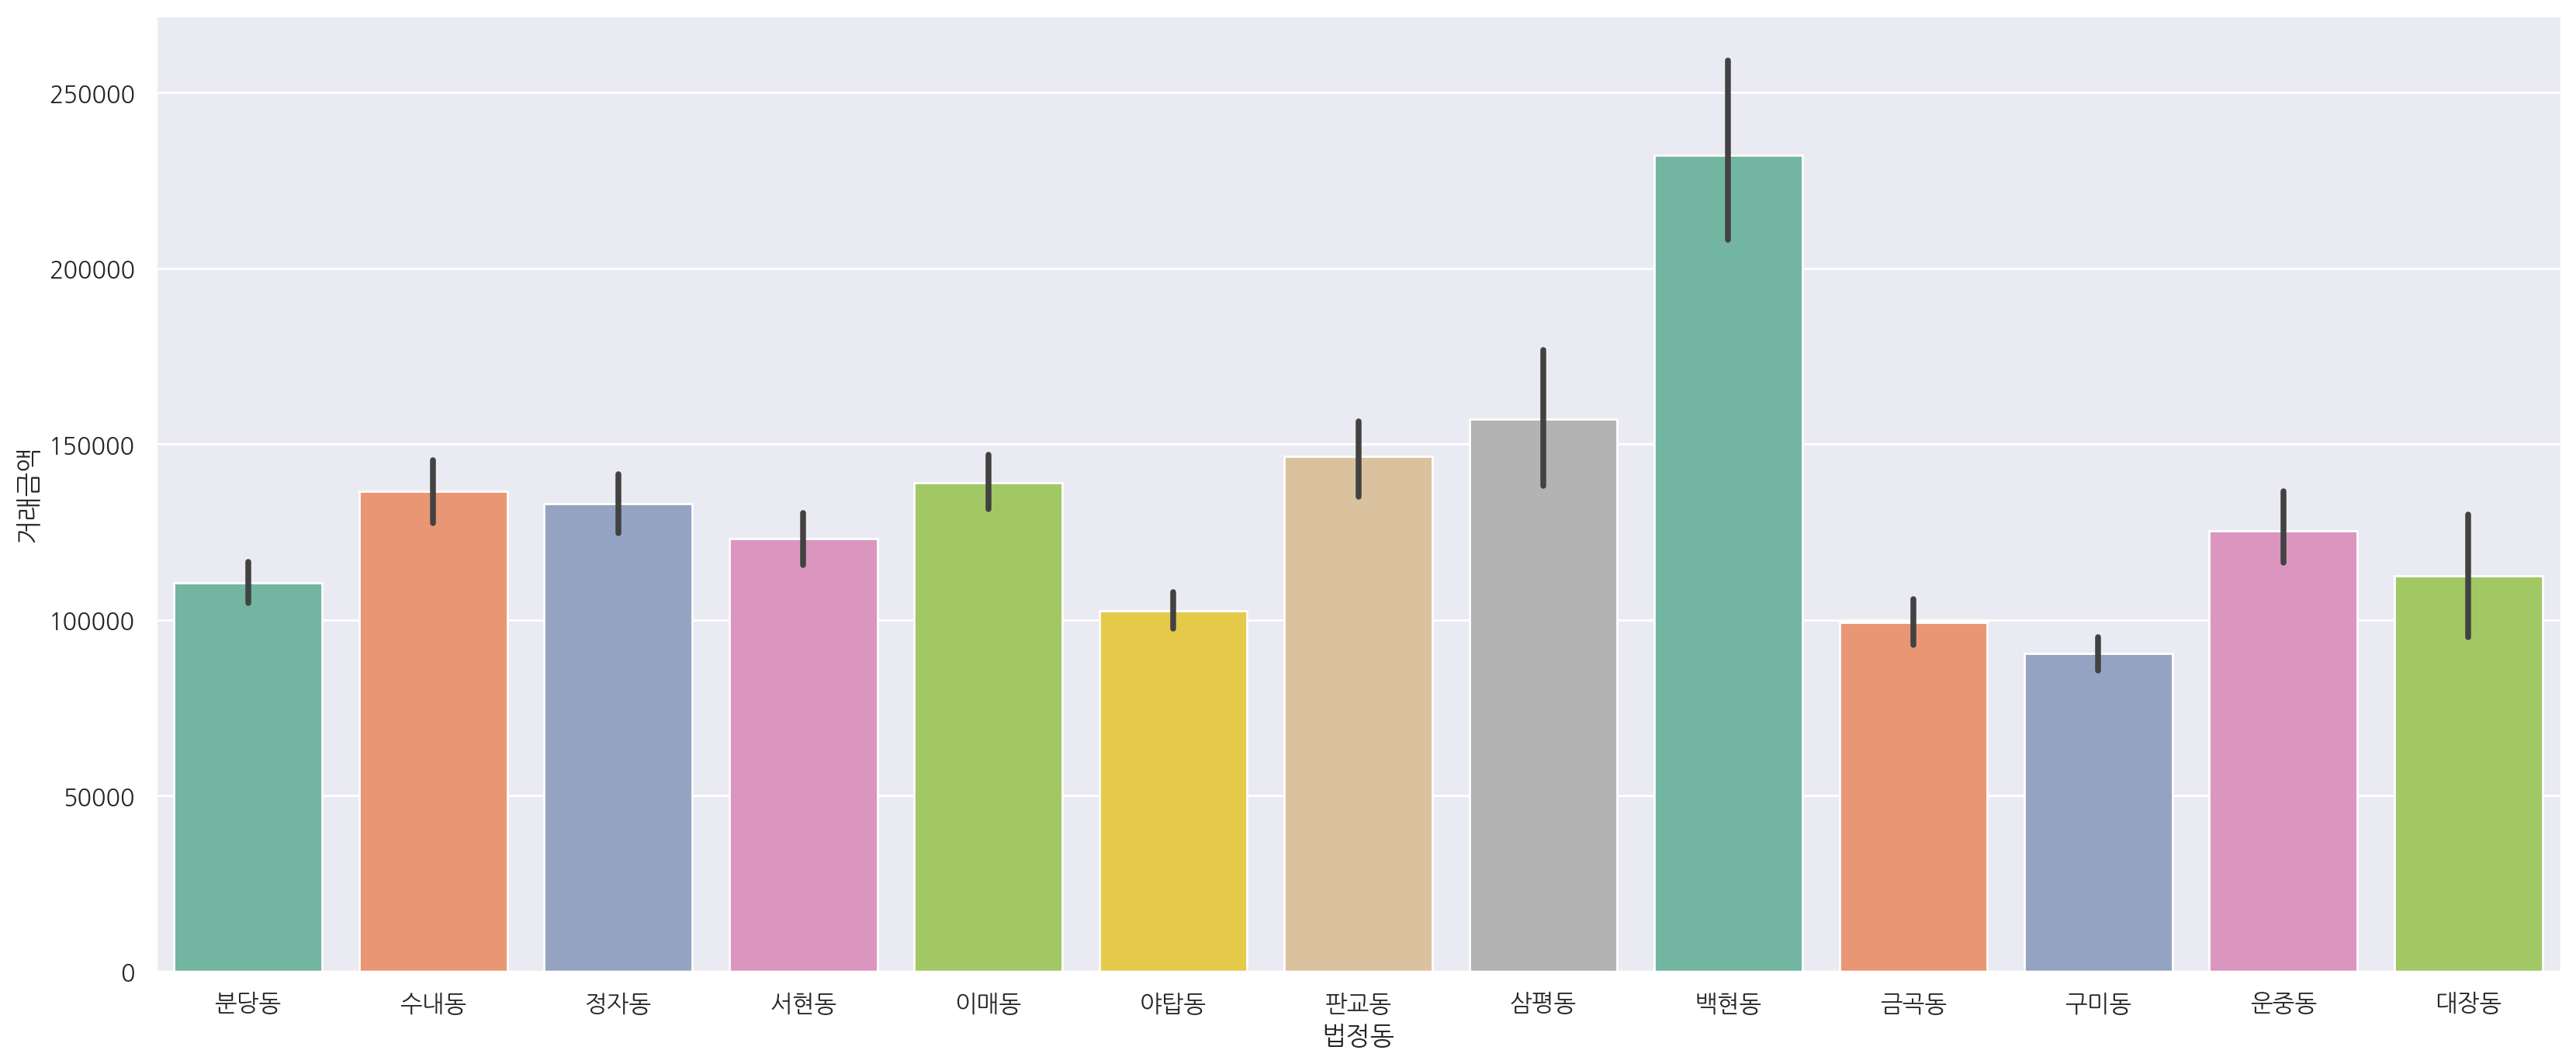

In [27]:
%matplotlib inline 

plt.figure(figsize=(20,8))
sns.set_style('darkgrid')
plt.rc('font', family='Nanumgothic')

sns.barplot(data=df, x="법정동" , y ='거래금액', palette='Set2')
plt.show

### 거래가격 이상치에 해당되는 아파트

In [28]:
#IQR = Q3- Q1 을 이용하여 이상치의 개수를 구해보기
q3 = df["거래금액"].quantile(0.75) 
q1 = df["거래금액"].quantile(0.25)

iqr = q3 - q1
out_cut = iqr * 1.5

# lower , upper bound
lower , upper = q1 - out_cut , q3 + out_cut

out_money1 = df["거래금액"] > upper
out_money2 = df["거래금액"] < lower

# 이상치에 해당되는 행 인덱스 구하기
out_index = df.index[out_money1 == True].tolist()

# 전체 데이터프레임에서 행인덱스를 이용하여 필요한 데이터 추출하기
df_top = df.loc[out_index]
display(pd.DataFrame(df_top["법정동"].value_counts()).T)

,정자동,백현동
법정동,11,8


In [29]:
df_top.groupby(['법정동','아파트']).size().reset_index(name='count')

,법정동,아파트,count
0,백현동,THESHARP판교퍼스트파크,1
1,백현동,백현마을8단지(대림),1
2,백현동,판교알파리움1단지,1
3,백현동,판교알파리움2단지,1
4,백현동,판교푸르지오그랑블,4
5,정자동,미켈란쉐르빌,1
6,정자동,분당파크뷰,7
7,정자동,현대I-PARK1,3


<AxesSubplot:xlabel='법정동', ylabel='count'>

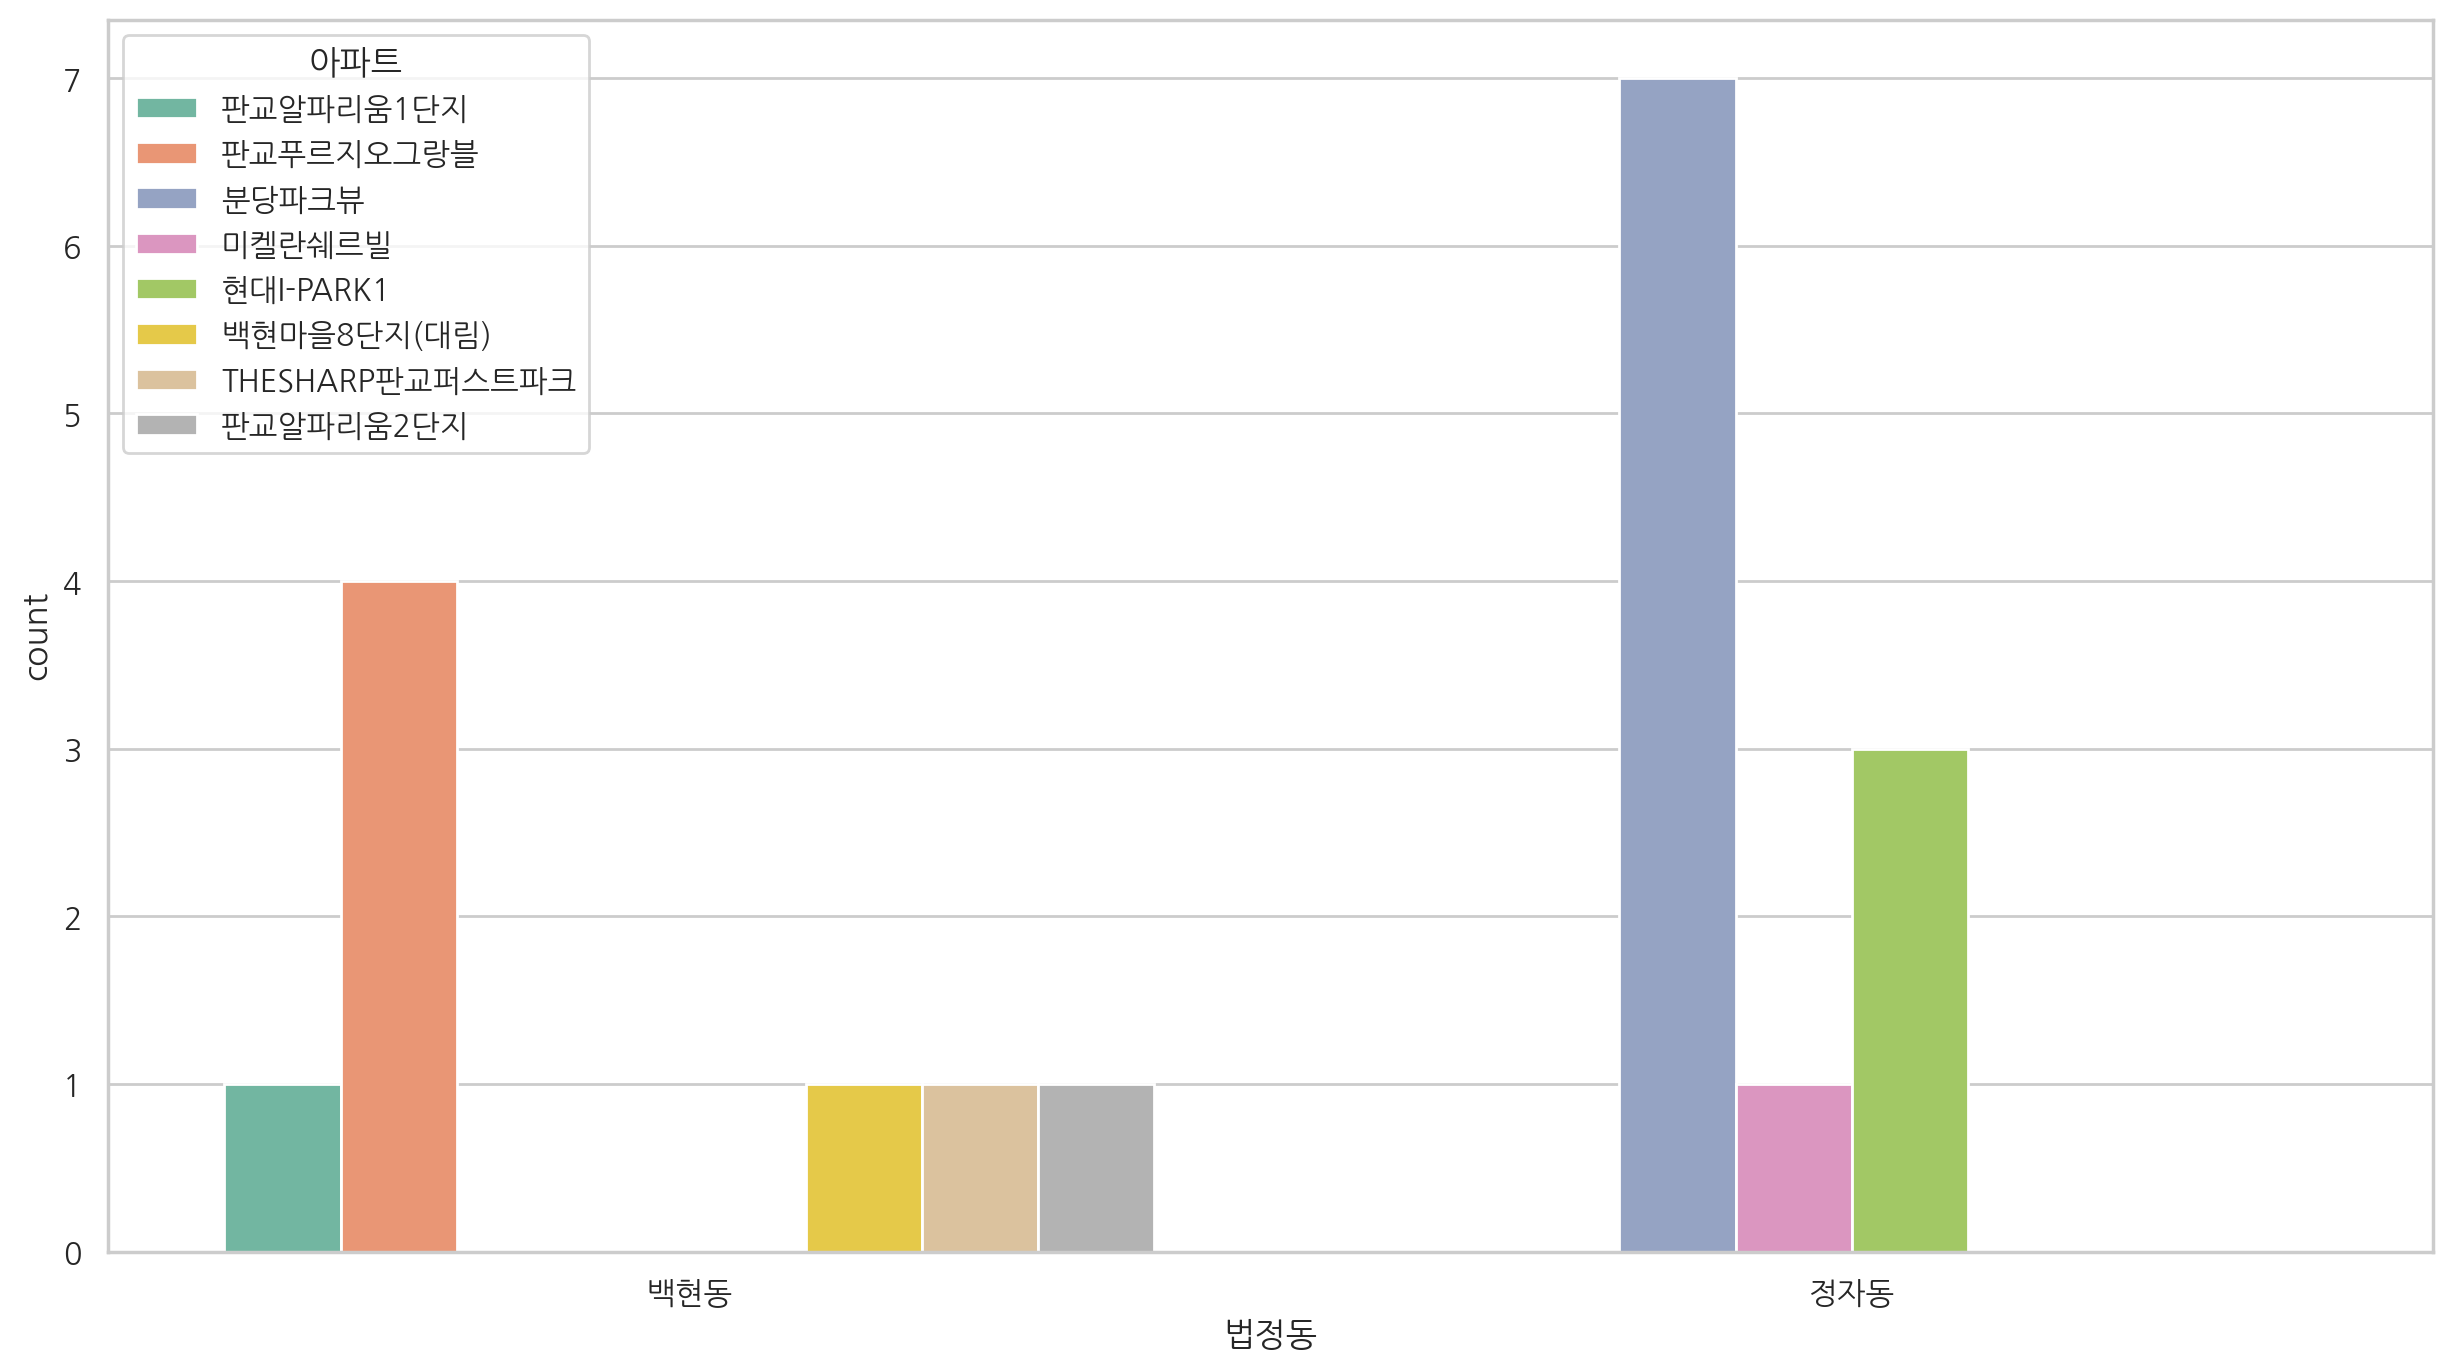

In [30]:
plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
plt.rc('font', family='NanumGothic') 

sns.countplot(data=df_top, x="법정동" , hue='아파트', palette='Set2')

### 거래가격 상관분석

In [31]:
# 모두 양의 상관관계 : 층수가 높아지거나, 전용면적이 넓어지거나 , 건축년도가 최신일수록 거래금액도 올라가는 경향이 보인다.
df[['건축년도','층','전용면적','거래금액']].corr()

,건축년도,층,전용면적,거래금액
건축년도,1.000000,0.240191,0.214850,0.377153
층,0.240191,1.000000,0.242705,0.342920
전용면적,0.214850,0.242705,1.000000,0.830211
거래금액,0.377153,0.342920,0.830211,1.000000


<AxesSubplot:>

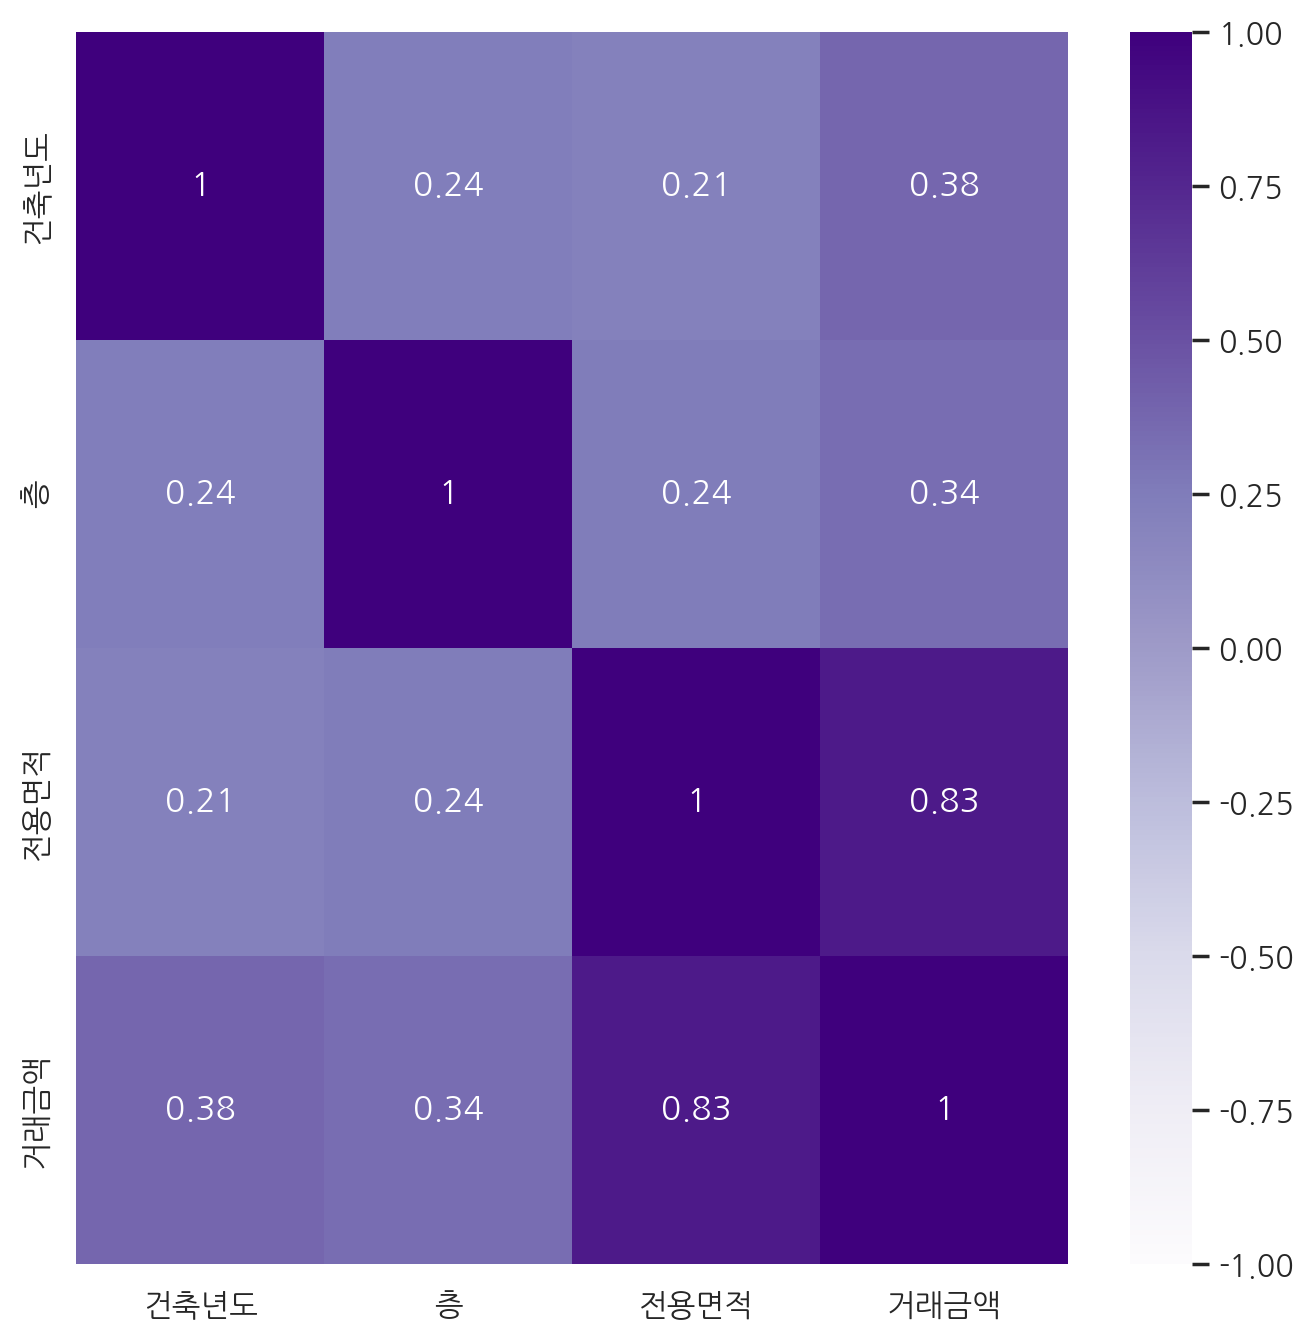

In [32]:
#heatmap으로 상관관계를 표시
plt.rcParams["figure.figsize"] = (8,8)
plt.rc('font', family='NanumGothic') 
sns.heatmap(df[['건축년도','층','전용면적','거래금액']].corr(),
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Purples', #색상
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
          )

### (참고) XML 파일 처리
https://codealone.tistory.com/77

In [33]:
tree = ET.fromstring(response.content)
# ET.dump(tree) # .dump : xml 요소의 내용 출력 (response.text와 형태 비슷)
ET.indent(tree, space = ' ') # 들여쓰기 처리(가독성)
ET.dump(tree)

<response>
 <header>
  <resultCode>00</resultCode>
  <resultMsg>NORMAL SERVICE.</resultMsg>
 </header>
 <body>
  <items>
   <item>
    <거래금액>   155,000</거래금액>
    <거래유형>중개거래</거래유형>
    <건축년도>2016</건축년도>
    <년>2023</년>
    <도로명>왕십리로</도로명>
    <도로명건물본번호코드>00410</도로명건물본번호코드>
    <도로명건물부번호코드>00000</도로명건물부번호코드>
    <도로명시군구코드>11200</도로명시군구코드>
    <도로명일련번호코드>00</도로명일련번호코드>
    <도로명코드>3005011</도로명코드>
    <법정동> 하왕십리동</법정동>
    <법정동본번코드>1070</법정동본번코드>
    <법정동부번코드>0000</법정동부번코드>
    <법정동시군구코드>11200</법정동시군구코드>
    <법정동읍면동코드>10200</법정동읍면동코드>
    <법정동지번코드>1</법정동지번코드>
    <아파트>센트라스</아파트>
    <월>1</월>
    <일>11</일>
    <일련번호>11200-3120</일련번호>
    <전용면적>84.96</전용면적>
    <중개사소재지>서울 성동구</중개사소재지>
    <지번>1070</지번>
    <지역코드>11200</지역코드>
    <층>21</층>
    <해제사유발생일> </해제사유발생일>
    <해제여부> </해제여부>
   </item>
   <item>
    <거래금액>    83,000</거래금액>
    <거래유형>중개거래</거래유형>
    <건축년도>2000</건축년도>
    <년>2023</년>
    <도로명>행당로</도로명>
    <도로명건물본번호코드>00079</도로명건물본번호코드>
    <도로명건물부번호코드>00000</도로명건물부번호코드>
    <도로명시군구코드>1

In [34]:
# 파일 내 태그트리 구성형태대로 리스트화 되어 있음
# response[header[resultCode, resultMsg],body[items[item, item …], …]

items = tree[1][0] # body 태그 안의 items의 위치

# 컬럼과 내용 저장
columns = [i.tag for i in items[1]]
items_list = [[i.text for i in item] for item in items]

In [35]:
df = pd.DataFrame(items_list, columns = columns)

In [36]:
df

,거래금액,거래유형,건축년도,년,도로명,도로명건물본번호코드,도로명건물부번호코드,도로명시군구코드,도로명일련번호코드,도로명지상지하코드,...,월,일,일련번호,전용면적,중개사소재지,지번,지역코드,층,해제사유발생일,해제여부
0,"155,000",중개거래,2016,2023,왕십리로,00410,00000,11200,00,3005011,...,11,11200-3120,84.96,서울 성동구,1070,11200,21,,,None
1,"83,000",중개거래,2000,2023,행당로,00079,00000,11200,01,0,...,1,9,11200-18,59.96,서울 성동구,347,11200,6,,
2,"129,000",중개거래,2003,2023,고산자로,00164,00000,11200,04,0,...,1,11,11200-24,114.97,서울 성동구,349,11200,14,,
3,"186,000",중개거래,2007,2023,금호로,00015,00000,11200,03,0,...,1,14,11200-2820,84.87,서울 성동구,340,11200,17,,
4,"133,000",중개거래,2012,2023,매봉길,00015,00000,11200,02,0,...,1,9,11200-2980,59.25,서울 성동구,561,11200,18,,
5,"124,000",중개거래,2016,2023,매봉길,00050,00000,11200,00,4109229,...,19,11200-3114,59.91,서울 성동구,528,11200,6,,,None
6,"101,000",중개거래,1990,2023,서울숲길,00025,00000,11200,01,0,...,1,2,11200-61,84.73,서울 성동구,676-5,11200,13,,
